# RNN 循环神经网络

主要就是H层计算公式中增加的隐变量，引入时序信息。

需要注意的是：输入Xt表示为时间或者序列t时刻的样本，假如样本只有一行[1,2,3,4] 时间t=0的时候样本就是1，对应的label是2，t=2的时候样本是3 对应label是4

## 简单演示RNN的隐变量公式和输出公式

In [3]:
import torch
from d2l import torch as d2l

# 定义样本和处理输入X的矩阵W_xh
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
# 定义隐藏层H和处理前一个隐藏层的W_hh矩阵
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
# 实现更新 Ht = 激活(Xt·W_xh + Ht-1 · W_hh)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 1.7656, -1.7364, -1.1154, -0.6293],
        [-0.2943,  0.0261, -0.0419,  0.2159],
        [-3.0809,  3.8483, -1.2955, -2.7977]])

In [ ]:
# 上面的操作可以简写为下面这种
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.7656, -1.7364, -1.1154, -0.6293],
        [-0.2943,  0.0261, -0.0419,  0.2159],
        [-3.0809,  3.8483, -1.2955, -2.7977]])

## 正式实现

In [ ]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 定义批量大小，序列长度
batch_size, num_steps = 32, 35
# 读取时间旅行这本书的内容，得到数据迭代器和vocab对象（包含词典和转换等）
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [8]:
# 需要注意：这里读取的这本书进行分词，基础单位是字符，不是单词
len(vocab) # 总共28个字符包含未知，字母表的字母,空

28

In [ ]:
# 实践证明，独热编码比直接输入索引要好
# 因为不用独热编码，每个批次每个时间步输入是一个标量，用标量*矩阵得到的结果表示的信息太少
# 独热编码函数：生成vocab长度的向量，两个数据0，2，表示位置0为1和位置2为0的两个向量
F.one_hot(torch.tensor([0, 2]), len(vocab))
# 对这些字符进行独热编码
X = torch.arange(10).reshape((2, 5))# 批次2，时间步数为5  的数据，每个时间步对应数据需要变为独热编码
F.one_hot(X.T, 28).shape # 时间步数，批量大小，词表大小    5个时间步，每个时间步两个长为28的向量
# 可能不好理解，距离，结果[0]表示原来的 批次2，时间5 的数据的第一列的两个数据，现在这两个数据都是独热编码的向量了
# 所以 结果[0]代表：时间0的两个批次的独热编码向量

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])


torch.Size([5, 2, 28])

In [ ]:
# 初始化模型参数，就是两个公式里出现的参数，隐变量和输入不算模型参数不需要计算梯度
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [ ]:
# 定义模型的初始隐状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [17]:
# 定义模型计算  实现第一第二个公式的计算
# 输入批次数据，上一次的隐变量，所有模型参数
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        # tanh激活函数
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [15]:
# 用上面的函数，定义完整RNN模型类
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [35]:
# 简单测试
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [ ]:
# 预测，先利用用户提供的字符串预热，更新隐状态

def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # 得到第一个字符在词典的编码
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [28]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller uuuuuuuuuu'

In [30]:
# 梯度裁剪 避免梯度爆炸

def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 计算范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    # 如果范数超过阈值，将所有梯度数据拉到阈值内，避免多个矩阵乘法后梯度爆炸
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
# 训练每个批次数据
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            #  因此当前小批量数据最后一个样本的隐状态， 将用于初始化下一个小批量数据第一个样本的隐状态。 
            # 这样，存储在隐状态中的序列的历史信息 可以在一个迭代周期内流经相邻的子序列。
            # 然而，在任何一点隐状态的计算， 都依赖于同一迭代周期中前面所有的小批量数据， 这使得梯度计算变得复杂。 
            # 为了降低计算量，在处理任何一个小批量数据之前， 我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_() 
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
# 训练
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 预测50步
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 21314.2 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


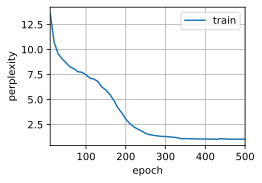

In [33]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 21974.2 词元/秒 cuda:0
time travellerit s against reason said filbycan a cube that does
travellerit s against reason said filbycan a cube that does


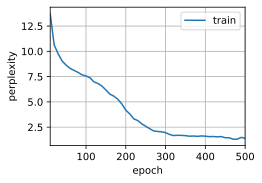

In [34]:
# 随机采样的效果
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

## 简洁实现

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [3]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
# 这里观察Y可以看到Y的形状是 35,32,256：35是预测的序列，每个序列32个批次数据，每个数据是一个256的向量
# 这说明nn.RNN实际只实现了第一个公式，而第二个输出的公式没有实现
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [7]:
# 定义RNN类，需要定义输出层
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
# 先看看不训练的预测结果
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellertyyxkkkkkk'

perplexity 1.3, 157179.4 tokens/sec on cuda:0
time traveller proceeded anyreal body must have extension in fou
travellerit would stare dras ams have impasmed in our githe


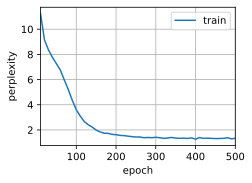

In [9]:
# 训练
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)